In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression,\
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import mliv.dgps_mediated as dgps
from mliv.ensemble import EnsembleIV, EnsembleIVStar
from mliv.rkhs import ApproxRKHSIVCV
from mliv.shape import LipschitzShapeIV, ShapeIV
from mliv.linear import OptimisticHedgeVsOptimisticHedge, StochasticOptimisticHedgeVsOptimisticHedge
from mliv.linear import L2OptimisticHedgeVsOGD, L2ProxGradient
from sklearn.pipeline import Pipeline

from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import AGMM, KernelLayerMMDGMM, CentroidMMDGMM, KernelLossAGMM, MMDGMM
from mliv.tsls import tsls, regtsls

p = 0.1  # dropout prob of dropout layers throughout notebook
n_hidden = 100  # width of hidden layers throughout notebook

# For any method that use a projection of z into features g(z)
g_features = 100

# The kernel function
kernel_fn = gaussian
# kernel_fn = inverse_multiquadric

# Training params
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-3
adversary_l2 = 1e-4
adversary_norm_reg = 1e-3
n_epochs = 300
bs = 100
sigma = 2.0 / g_features
n_centers = 100
device = torch.cuda.current_device() if torch.cuda.is_available() else None


In [2]:
from dml_mediated import DML_mediated

In [3]:
fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)
tauinv_fn = dgps.get_tauinv_fn(fn_number)
W, Z, X, M, D, Y, tau_fn = dgps.get_data(2000, tau_fn)

V = np.random.rand(Y.shape[0])
V = V.reshape(-1, 1)

print(np.column_stack((W,X,Z)).shape)
ind = np.where(D==0)[0]
W0 = W[ind]
X0 = X[ind,:]
W0_test = np.zeros((1000, 1+X.shape[1]))
W0_test += np.median(np.column_stack((X0,W0)), axis=0, keepdims=True)
W0_test[:, 2] = np.linspace(np.percentile(
            W0[:, 0], 5), np.percentile(W0[:, 0], 95), 1000)

# True parameters
b_yd = 2.0; b_ym = 1.0; b_yx = np.array([[-1.0],[-1.0]]); b_yu = -1.0; b_yw = 2.0; b_y0 = 2.0
b_wx = np.array([[0.2],[0.2]]); b_wu = -0.6; b_w0 = 0.3
b_md = -0.3; b_mx = np.array([[-0.5],[-0.5]]); b_mu = 0.4; b_m0 = 0.0
    
gamma_1w = (b_yw*b_wu + b_yu)/b_wu
gamma_1x = b_yw*b_wx + b_yx - gamma_1w*b_wx
gamma_1m = b_ym
gamma_10 = b_y0 + b_yd + b_yw*b_w0 - gamma_1w*b_w0

gamma_0w = (gamma_1m*b_mu + gamma_1w*b_wu)/b_wu
gamma_0x = gamma_1m*b_mx + gamma_1w*b_wx + gamma_1x - gamma_0w*b_wx
gamma_00 = gamma_10 + gamma_1m*b_m0 + gamma_1w*b_w0 - gamma_0w*b_w0

    # True nuisance function
expected_te = gamma_00 + tauinv_fn(W0_test)@np.row_stack((gamma_0x, gamma_0w))


(2000, 4)


In [4]:
rkhs_model = ApproxRKHSIVCV(kernel_approx='nystrom', n_components=100,
                           kernel='rbf', gamma=.1, delta_scale='auto',
                           delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5)

def _get_learner(n_t):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary_g(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, g_features), nn.ReLU())


agmm_1 = AGMM(_get_learner(4),_get_adversary(4))
agmm_2 = AGMM(_get_learner(3),_get_adversary(3))

In [5]:
dml_rkhs = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3)

dml_agmm = DML_mediated(Y, D, M, W, Z, X,
                        model1 = agmm_1,
                        model2 = agmm_2,
                        modelq1 = agmm_2,
                        modelq2 = agmm_1,
                        n_folds=5, n_rep=1,
                        CHIM = False,
                        nn_1 = True,
                        nn_2 = True,
                        nn_q1 = True,
                        nn_q2 = True,
                        fitargs1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4, 'adversary_norm_reg' : 1e-3},
                        fitargs2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        opts = {'lin_degree': 1, 'burnin': 200})

dml_2sls = DML_mediated(Y, D, M, W, Z, X,
                        model1 = tsls(),
                        model2 = tsls(),
                        modelq1 = tsls(),
                        modelq2 = tsls(),
                n_folds=10, n_rep=3)

dml_2sls_chim = DML_mediated(Y, D, M, W, Z, X,
                        model1 = tsls(),
                        model2 = tsls(),
                        modelq1 = tsls(),
                        modelq2 = tsls(),
                        CHIM=True,
                n_folds=10, n_rep=3)


dml_rfiv = DML_mediated(Y, D, M, W, Z, X,
                        model1 = EnsembleIV(n_iter=200, max_abs_value=2),
                        model2 = EnsembleIV(n_iter=200, max_abs_value=2),
                        modelq1 = EnsembleIV(n_iter=200, max_abs_value=2),
                        modelq2 = EnsembleIV(n_iter=200, max_abs_value=2),
                n_folds=5, n_rep=1)    


In [6]:
dml_rkhs_or = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3, estimator='OR')

dml_rkhs_ipw = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3, estimator='IPW')

dml_rkhs_hybrid = DML_mediated(Y, D, M, W, Z, X,
                        model1 = rkhs_model,
                        model2 = rkhs_model,
                        modelq1 = rkhs_model,
                        modelq2 = rkhs_model,
                n_folds=5, n_rep=3, estimator='hybrid')


In [15]:
print(dml_rkhs.dml())

Rep: 1


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Rep: 2


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Rep: 3


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

(4.042785919417782, 29.7095548009198, array([3.80390516, 4.28166668]))


In [16]:
print(dml_rkhs_or.dml())

Rep: 1


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Rep: 2


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Rep: 3


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

(4.039927024378075, 11.404901870033441, array([3.89192118, 4.18793287]))


In [17]:
print(dml_rkhs_ipw.dml())

Rep: 1


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Rep: 2


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Rep: 3


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

(3.8666126997583103, 53.52630884081993, array([3.54597341, 4.18725199]))


In [18]:
print(dml_rkhs_hybrid.dml())

Rep: 1


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Rep: 2


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Rep: 3


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

(4.016071805373283, 59.10488717336213, array([3.67913784, 4.35300577]))


In [8]:
print(dml_2sls.dml())
print(dml_2sls_chim.dml())

Rep: 1


100%|██████████| 10/10 [00:00<00:00, 18.11it/s]


Rep: 2


100%|██████████| 10/10 [00:00<00:00, 13.35it/s]


Rep: 3


100%|██████████| 10/10 [00:00<00:00, 13.88it/s]


(3.9897819641864416, 24.675050727581464, array([3.77208011, 4.20748381]))
Rep: 1


100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Rep: 2


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Rep: 3


100%|██████████| 10/10 [00:00<00:00, 11.59it/s]

(3.989879135825183, 24.586854572316195, array([3.7725667 , 4.20719157]))


In [9]:
_ , gamma_0 = dml_2sls._nnpivfit_outcome(Y=Y, D=D, M=M, W=W, X=X, Z=Z)
gamma0_hat = gamma_0.predict(W0_test)


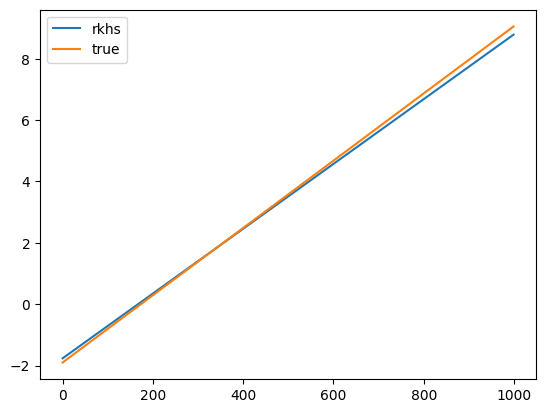

In [10]:

plt.show()
plt.plot(gamma0_hat)
plt.plot(expected_te)
plt.legend(['rkhs', 'true'])

In [11]:

print(np.mean(gamma_0.predict(np.column_stack((X, W)))))
#In principle this should be the same as the 'OR' estimator


3.9851882798967546


In [12]:
dml_2sls.dml()

Rep: 1


100%|██████████| 10/10 [00:00<00:00, 19.10it/s]


Rep: 2


100%|██████████| 10/10 [00:00<00:00, 14.20it/s]


Rep: 3


100%|██████████| 10/10 [00:00<00:00, 18.54it/s]


(3.9897819641864416, 24.675050727581464, array([3.77208011, 4.20748381]))

In [13]:
dml_reg2sls = DML_mediated(Y, D, M, W, Z, X,
                           estimator='MR',
                        model1 = regtsls(),
                        model2 = regtsls(),
                        modelq1 = regtsls(),
                        modelq2 = regtsls(),
                n_folds=10, n_rep=3)     


dml_reg2sls.dml()

Rep: 1


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Rep: 2


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Rep: 3


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


(3.9897382786260955, 24.739534227996725, array([3.77175215, 4.2077244 ]))

In [14]:
percentiles = np.arange(5, 100, 5)
v_values = np.percentile(V, percentiles)

dml_2sls = DML_mediated(Y, D, M, W, Z, X, V=V,
                        v_values=v_values,
                        loc_kernel = 'gau',
                        bw_loc = 'scott',
                        model1 = tsls(),
                        model2 = tsls(),
                        modelq1 = tsls(),
                        modelq2 = tsls(),
                n_folds=10, n_rep=3)

theta, vart, ci = dml_2sls.dml()

print(theta)
print(np.mean(theta, axis=0))
print(vart)
print(ci)


Rep: 1


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Rep: 2


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Rep: 3


100%|██████████| 10/10 [00:01<00:00,  6.17it/s]

[4.16805091 4.03289225 4.03900938 4.18445646 4.31249635 4.36623252
 4.34511055 4.19965223 3.96978413 3.71756127 3.70742401 3.92459108
 4.15848892 4.33431323 4.27298306 3.96706468 3.46720289 3.24483498
 3.22016827]
3.980648272739806
[262.9805494  192.87720224 176.99752368 185.62071486 177.35623236
 162.19985124 158.79704472 153.7201157  142.51291843 131.43206493
 133.30882971 148.33516278 157.89867421 162.75275107 161.92673592
 154.3162788  152.64740953 161.97990158 190.60169256]
[[3.45733685 4.87876497]
 [3.42423396 4.64155054]
 [3.45594477 4.622074  ]
 [3.5873575  4.78155542]
 [3.72884121 4.8961515 ]
 [3.80807302 4.92439202]
 [3.79283693 4.89738417]
 [3.65627874 4.74302572]
 [3.4465932  4.49297507]
 [3.21512179 4.22000075]
 [3.20140999 4.21343803]
 [3.39081987 4.4583623 ]
 [3.60777971 4.70919812]
 [3.77520323 4.89342323]
 [3.71529368 4.83067244]
 [3.42263855 4.51149081]
 [2.92572863 4.00867714]
 [2.68705406 3.80261591]
 [2.61511102 3.82522552]]
